# Loading modules

In [ ]:
import os
import numpy as np
import random
from PIL import Image,ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# keras

from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout # type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.applications import VGG16 # type: ignore
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize


# Loading Data

In [2]:
# Data dir paths
train_dir = './Training'
test_dir = './Testing'

# training data loading
train_labels = []
train_paths = []

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir,label,image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths,train_labels)

# testing data loading
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir,label)):
    test_paths.append(os.path.join(test_dir,label,image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Setting image size
IMAGE_SIZE = 128

# Data visualization

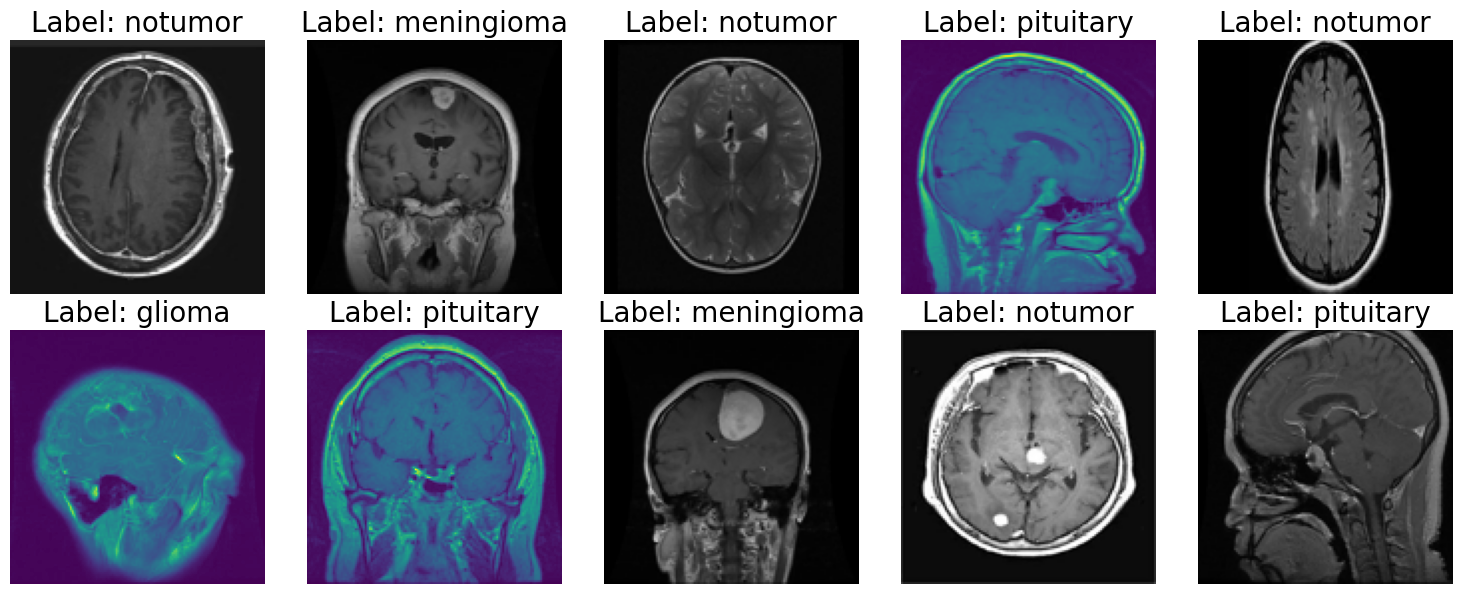

In [ ]:

# Sampling random indices from image data
random_idx = random.sample(range(len(train_paths)),10)

# creating fig and axes

fig, axes = plt.subplots(2,5, figsize=(15,6))
axes = axes.ravel()

for i,idx in enumerate(random_idx):
  # Getting img path and label
  img_path = train_paths[idx]
  img_label = train_labels[idx]

  #loading the resized img
  img = Image.open(img_path).resize((128,128))

  # Displaying random image data
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f'Label: {img_label}', fontsize=20)

plt.tight_layout()
plt.show()

# Class Distribution

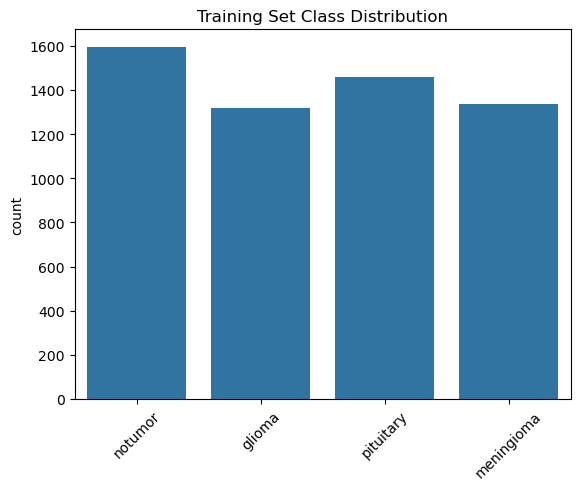

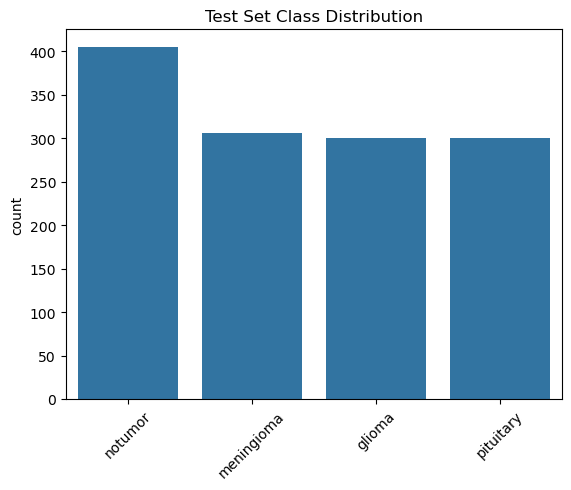

In [20]:
sns.countplot(x=train_labels)
plt.title("Training Set Class Distribution")
plt.xticks(rotation=45)
plt.show()

sns.countplot(x=test_labels)
plt.title("Test Set Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Image preprocessing (Defining helper functions)

In [5]:
# Image Augmentation (Enhance and augment the image data)
def augment_image(image):
  # Convert to image object
  image = Image.fromarray(np.uint8(image))

  # Image enhancement
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))

  # Converting to comprehensive np array
  image = np.array(image)/255.0
  return image

# Open images and initialize augmentation
def open_images(paths):
  images = []

  # Looping through all image paths
  for path in paths:
    #loading and augmenting the img one by one and appending them to images array
    img = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
    img = np.array(img)
    img = augment_image(img)
    images.append(img)
  #returning img array as a numpy array
  return np.array(images)

# Label encoder (string label class -> int label class)
def label_encoder(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return encoded

# Data generator for batching (Increase performance and speed)
def data_gen(labels,paths,batch_size = 12,epochs = 1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i:i+batch_size]
      batch_labels = label_encoder(batch_labels)
      batch_labels = np.array(batch_labels) 
      yield batch_images, batch_labels

# Model

### Using pretrained model vgg16 (image model) for better accuracy and better proformance for our task

In [6]:
# VGG arch (128,128,3) (w,h,c)
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

# freeze all predefined layers
for layer in base_model.layers:
  layer.trainable = False

# Set only the last few layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))) # input layer
model.add(base_model) # VGG16 model
model.add(Flatten()) # Flatten layer
model.add(Dropout(0.3)) # Droupout layer (drop random 30 neurons) to avoid overfitting

model.add(Dense(128,activation='relu')) # Dense layer
model.add(Dropout(0.2)) # Dropout laye

model.add(Dense(len(os.listdir(train_dir)), activation='softmax')) # Output layer

# Compile the model

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Hyperparams
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 10


# Training model

history = model.fit(
  data_gen(train_labels,train_paths, batch_size=batch_size, epochs=epochs),
  epochs=epochs,
  steps_per_epoch = steps,
)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 104s 361ms/step - loss: 0.6905 - sparse_categorical_accuracy: 0.7231
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 98s 344ms/step - loss: 0.2533 - sparse_categorical_accuracy: 0.9042
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 98s 344ms/step - loss: 0.1734 - sparse_categorical_accuracy: 0.9349
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 98s 344ms/step - loss: 0.1182 - sparse_categorical_accuracy: 0.9526
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 98s 345ms/step - loss: 0.0724 - sparse_categorical_accuracy: 0.9700
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 98s 344ms/step - loss: 0.0606 - sparse_categorical_accuracy: 0.9766
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 99s 346ms/step - loss: 0.0470 - sparse_categorical_accuracy: 0.9821
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 98s 344ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9830
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 98s 343ms/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9863
Epoch 10/10
285/285 ━━━━━━━

# Train and val points

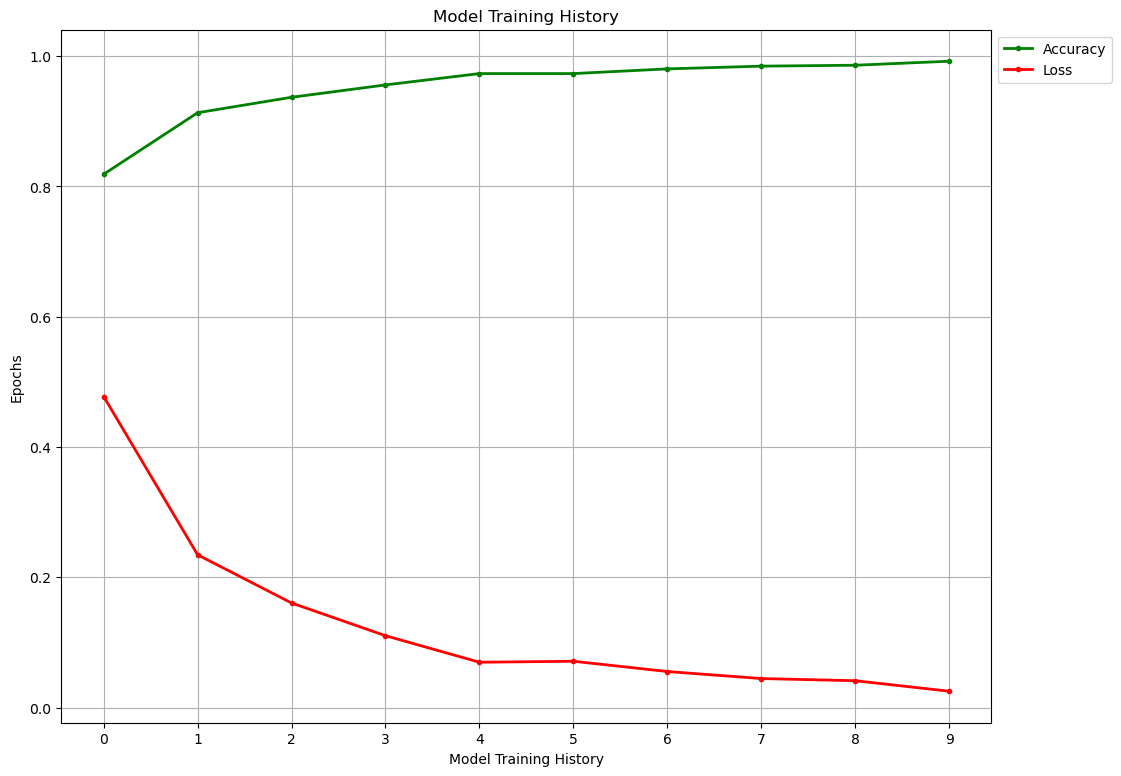

In [ ]:
plt.figure(figsize=(12,9))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('Model Training History')
plt.ylabel('Epochs')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy','Loss'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Model Classification Metrics Report

In [8]:
test_images = open_images(test_paths)
test_labels_encoded = label_encoder(test_labels)

test_prediction = model.predict(test_images)

print('classification Report: ')
print(classification_report(test_labels_encoded, np.argmax(test_prediction, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 401ms/step
classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       300
           1       0.89      0.96      0.93       306
           2       0.99      1.00      1.00       405
           3       0.98      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



# Confusion Matrix

Confusion Matrix
[[266  32   1   1]
 [  6 295   1   4]
 [  0   0 405   0]
 [  0   3   1 296]]


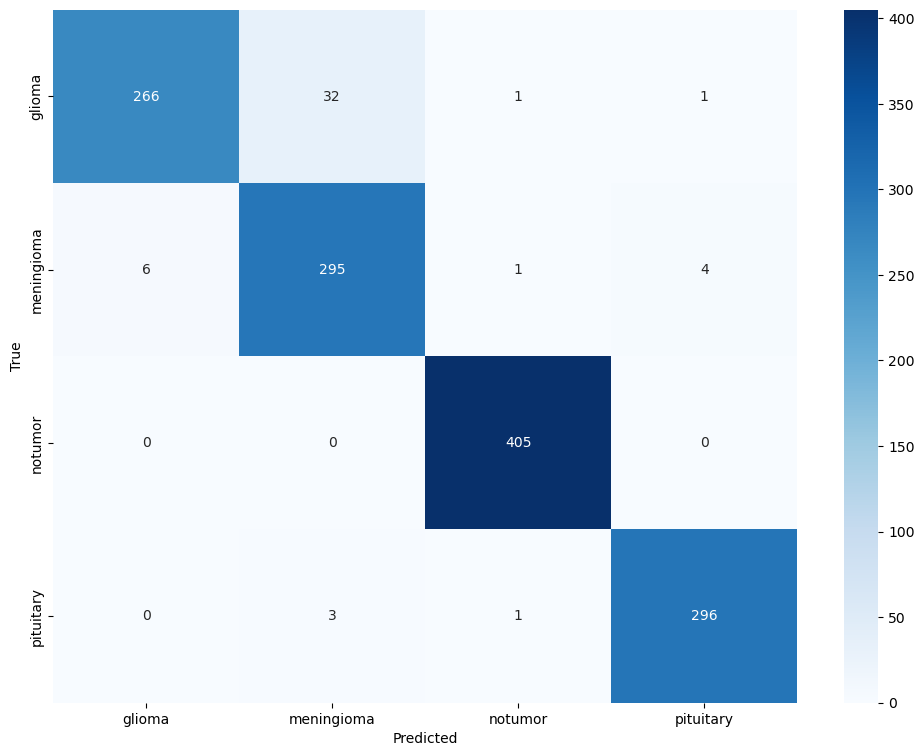

In [ ]:
cm = confusion_matrix(test_labels_encoded, np.argmax(test_prediction, axis=1))
print('Confusion Matrix')
print(cm)

plt.figure(figsize=(12,9))
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC curve plot

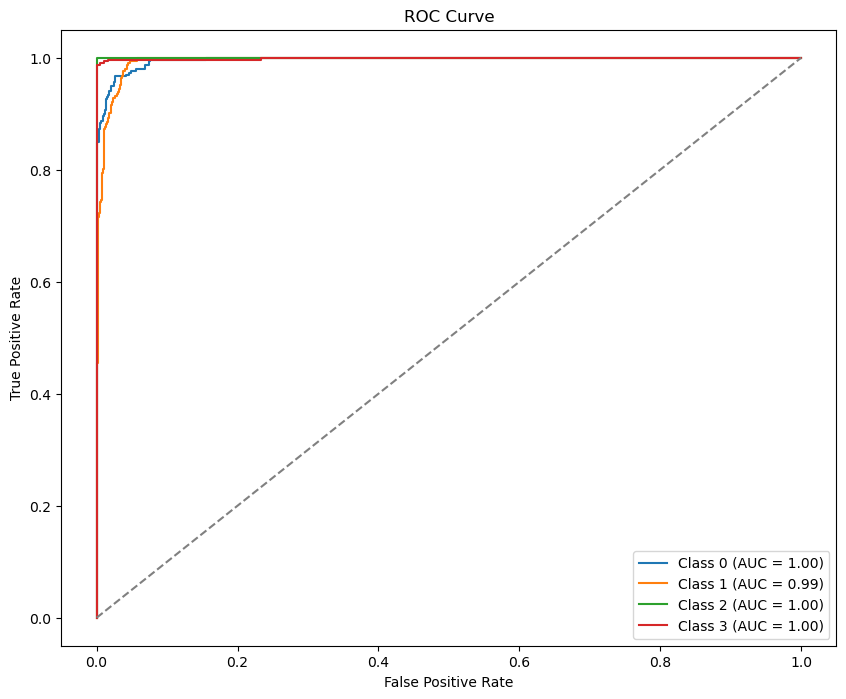

In [ ]:
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_prediction  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [11]:
model.save('model.keras')

# MRI Tumor Detection System

In [ ]:
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

def detect_and_display(image_path,model):
  try:
    # Load img
    print(image_path)
    img = load_img(image_path, target_size=(128,128))
    img_array = img_to_array(img)
    img = np.expand_dims(img_array, axis=0)

    # prediction
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    confidence_score = np.max(predictions,axis=1)[0]
    print(predicted_class)
    # determine the class

    if class_labels[predicted_class] == 'notumor':
      result =  'No Tumor Detected'
    else:
      result =  f'Tumor: {class_labels[predicted_class]}'

    plt.imshow(load_img(img_path))
    plt.axis('off')
    plt.title(f'{result} (Confidence:) {confidence_score * 100:.2f}%')
    plt.show()
  except Exception as e:
    print('Error processing the image: ', str(e))

# predictions

./Testing/meningioma/Te-me_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1


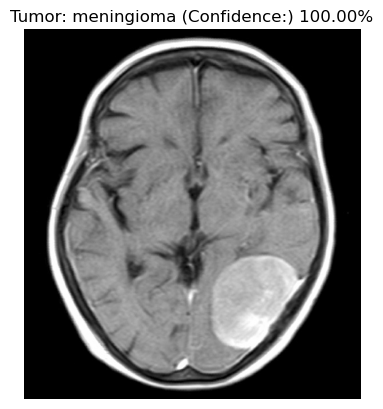

In [31]:
img_path = './Testing/meningioma/Te-me_0017.jpg'
detect_and_display(img_path, model)

Training/glioma/Tr-gl_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0


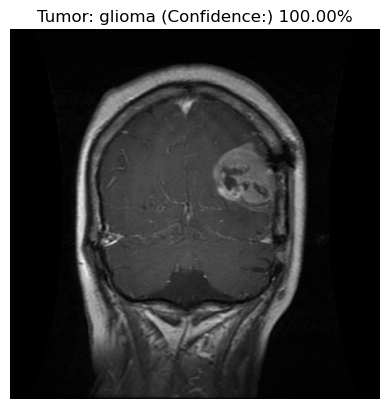

In [32]:
img_path = 'Training/glioma/Tr-gl_0021.jpg'
detect_and_display(img_path,model)

./Testing/notumor/Te-no_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2


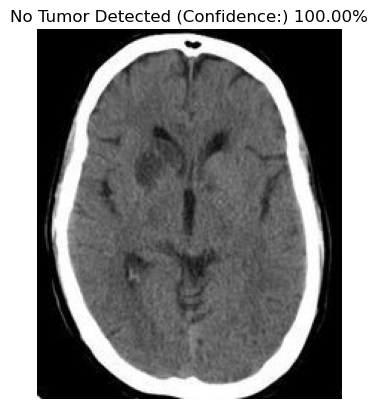

In [33]:
img_path = './Testing/notumor/Te-no_0010.jpg'
detect_and_display(img_path,model)

./Testing/pituitary/Te-piTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3


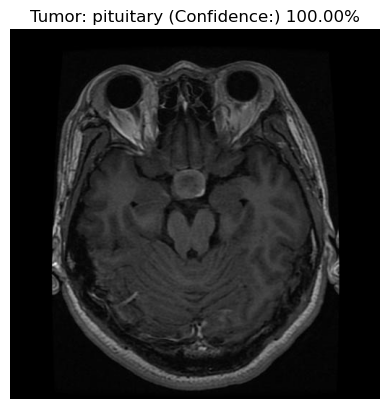

In [34]:
img_path = './Testing/pituitary/Te-piTr_0009.jpg'
detect_and_display(img_path,model)